# Intro

[Codebook](http://start.umd.edu/gtd/downloads/Codebook.pdf)

## For prediction of conflictual zones intensities

0. Estimate global risque metric (function of #death, #injured, ...)

1. Look at points (zones) in space (Middle east) over all years.
2. Graph too dense, merge data to smaller clusters (look for technique to do it efficiently)
3. Plot evolution over time or current situatation
4. Fit model prediction (step = month ?)

[Stationary signal processing on graphs](https://arxiv.org/pdf/1601.02522.pdf)

[Predicting the evolution of stationary graph signals](https://arxiv.org/pdf/1607.03313.pdf)

[A GRAPH DOWNSAMPLING TECHNIQUE BASED On GRAPH FOURIER TRANSFORM](https://arxiv.org/pdf/1612.07542.pdf)

In [1]:
import pandas as pd
import os
import numpy as np

%matplotlib inline

In [2]:
data_path = 'data'
gtd_path = os.path.join(data_path, 'globalterrorismdb_0617dist.csv')

In [3]:
df = pd.read_csv(gtd_path, encoding='latin', usecols=['eventid', 'iyear', 'imonth', 'iday', 
            'extended', 'resolution', 'region', 'latitude', 'longitude'])

/home/abbet/anaconda3/envs/ada/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.dtypes

eventid         int64
iyear           int64
imonth          int64
iday            int64
extended        int64
resolution     object
region          int64
latitude      float64
longitude     float64
dtype: object

In [5]:
df['region'].value_counts()

10    46511
6     41497
3     18762
8     16307
11    15491
5     11453
2     10340
9      5031
1      3346
4       794
7       554
12      264
Name: region, dtype: int64

In [6]:
df = df.dropna(subset=('longitude', 'latitude'))

In [7]:
len(df)

165744

In [8]:
df_ME = df[df['region'] == 10]
df_ME.loc[df_ME.imonth == 0, 'imonth'] = 1
df_ME.loc[df_ME.iday == 0, 'iday'] = 1

df_ME.loc[df_ME.iday == 0, 'iday'] 

/home/abbet/anaconda3/envs/ada/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Series([], Name: iday, dtype: int64)

In [9]:
import datetime
def parse_date(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])
    if month == 0:
        month = 1
    if day == 0:
        day = 1
    try:
        date = datetime.date(year, month, day)
    except Exception as e:
        date = datetime.date(year, month, 1)
    return date
df_ME['date'] = df_ME.eventid.apply(parse_date)

/home/abbet/anaconda3/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


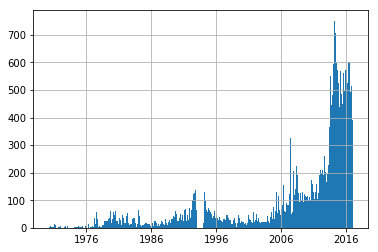

In [10]:
df_ME.date.hist(bins=45*12)

In [11]:
import folium

id_keep = np.random.permutation(np.arange(len(df_ME)))[:100]

mapit = folium.Map( location=[29.29, 42.55], zoom_start=4 )

for i, a in enumerate(df_ME.reset_index().loc[id_keep, ['latitude', 'longitude']].values):
    folium.Marker( location=[ a[0], a[1] ] ).add_to( mapit )
    if i%200 == 0:
        print(i)
mapit

0


In [12]:
df_ME_unique = df_ME.drop_duplicates(subset=('latitude', 'longitude'))

In [26]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

# Fit kNN for treated patient (arbitrary choice)
nn = NearestNeighbors(n_neighbors=10, metric='haversine')
nn.fit(df_ME_unique[['latitude', 'longitude']].values)
# Place non treated and find k=20 closest treated patients. We want many points to ensure good apprximation
# dists, id_dest = nn.kneighbors(np.expand_dims(df_n_treated.score.values, axis=1))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='haversine',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [27]:
dists, id_dest = nn.kneighbors(df_ME_unique[['latitude', 'longitude']].values)

In [28]:
B = nx.Graph()
B.add_nodes_from(df_ME_unique.eventid)

In [29]:
# Add all potential edges from set A (non treated) to set B (treated)
for i, id_src in enumerate(df_ME_unique.eventid):
    #print('\n', [ (id_src, df_ME_unique.iloc[dest]['eventid'], dist) for (dist, dest) in zip(dists[i], id_dest[i]) ] )
    edges = [ (id_src, df_ME_unique.iloc[dest]['eventid'], dist) for (dist, dest) in zip(dists[i], id_dest[i]) ]
    B.add_weighted_edges_from(edges)

In [30]:
edges

[(201612310027, 201612310027, 0.0),
 (201612310027, 201406170055, 1.4488762230383189e-05),
 (201612310027, 201409260059, 3.6217469292601547e-05),
 (201612310027, 201302250010, 0.00059454651268567673),
 (201612310027, 201402050015, 0.0012879808196824196),
 (201612310027, 201504260018, 0.0013817775622021423),
 (201612310027, 201408010056, 0.0014126083905854445),
 (201612310027, 200710090006, 0.0015208428566428269),
 (201612310027, 200601190009, 0.0021629530299599395),
 (201612310027, 200608030003, 0.0027922634996365272)]

In [37]:
comp = nx.algorithms.community.centrality.girvan_newman(B)